In [1]:
# amélioration affichage notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# import des bibliothèques utiles
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from tqdm.notebook import tqdm, trange
from pandas.plotting import scatter_matrix

# Import des données

In [15]:
path = './data/' 
hotels = pd.read_csv(path + '/features_hotels.csv')
data = pd.read_csv(path + 'data.csv')
data_test = pd.read_csv(path + 'test_set.csv')

In [16]:
# création de la colonne request_number dans le test set
data_test['request_number'] = 1
for avatar in np.unique(data_test['avatar_id']):
    data_test.loc[data_test['avatar_id'] == avatar, 'request_number'] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar])+1

    # suppression de la requête de l'avatar_id 134 qui pose problème
# print(data.loc[data.avatar_id == 134])
data = data.drop(index = data.loc[data.avatar_id == 134].index)
data = data.drop(['avatar_id'], axis = 1).drop_duplicates()

In [17]:
# ajout des caractéristiques des hotels
data = data.merge(hotels, on=['hotel_id','city'])
data_test = data_test.merge(hotels, on=['hotel_id','city'])
data_test = data_test.sort_values('index')    

In [18]:
data.head()

,city,date,language,mobile,request_number,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,amsterdam,12,german,1,1,567,91,3,Independant,Independant,1,0,0
1,amsterdam,27,estonian,0,1,567,81,15,Independant,Independant,1,0,0
2,amsterdam,11,slovakian,1,1,567,89,2,Independant,Independant,1,0,0
3,amsterdam,26,czech,0,1,567,83,14,Independant,Independant,1,0,0
4,amsterdam,25,croatian,1,1,567,83,13,Independant,Independant,1,0,0


# Mise en forme des données

In [19]:
colQT = ['request_number', 'stock', 'date']
colBool = ['mobile', 'pool', 'parking']
colQL = ['city', 'language', 'group', 'brand', 'children_policy']

In [20]:
for col in ['city', 'language', 'hotel_id', 'group', 'brand','children_policy','mobile','parking','pool'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)

# Analyse de Stock

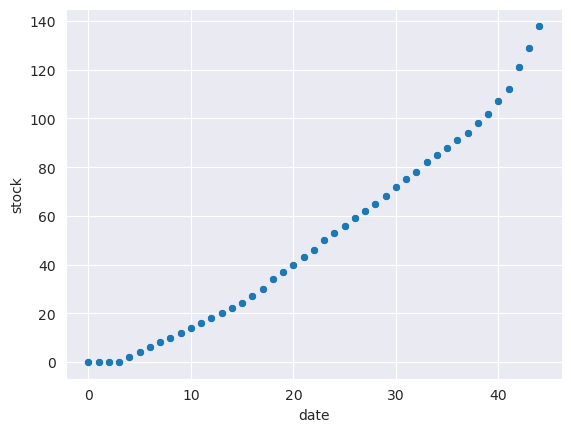

In [21]:
df_stock = data[['hotel_id','date','stock']].groupby(['hotel_id','date']).mean().reset_index()
test = df_stock.loc[df_stock.hotel_id == 500]
sns.scatterplot(data = test, x = 'date', y = 'stock')

plt.show()

On voit que les stocks diminuent au fil du temps, pour tous les hôtels les stocks diminuent de manière régulière en suivant une fonction simple. Nous pouvons facilement estimer les stocks à une certaine date même si nous n'avons pas fais de requêtes pour cette date.

# Exploration des données

## Analyse unidimensionnelle

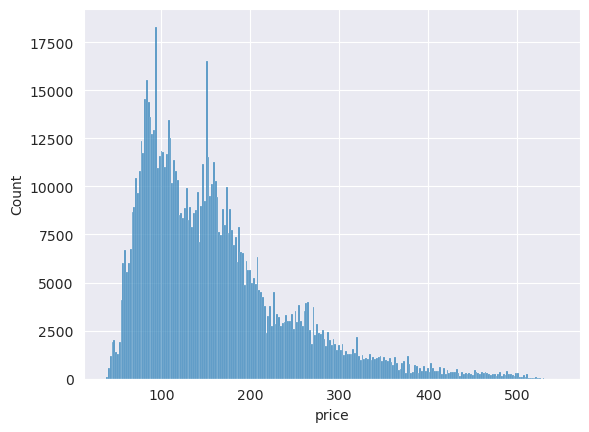

In [22]:
plt.figure()
sns.histplot(data['price'])
plt.show()

La majorité des prix est situé entre 80 et 150, il peut être intéressant de faire une transformation pour recentrer les prix et peut-être obtenir une distribution mieux répartie.

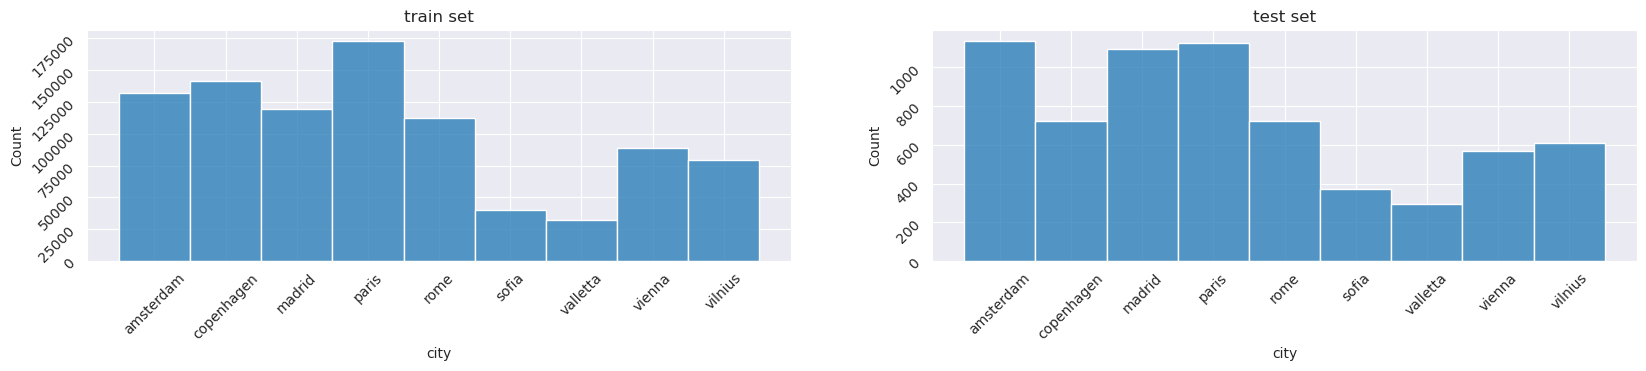

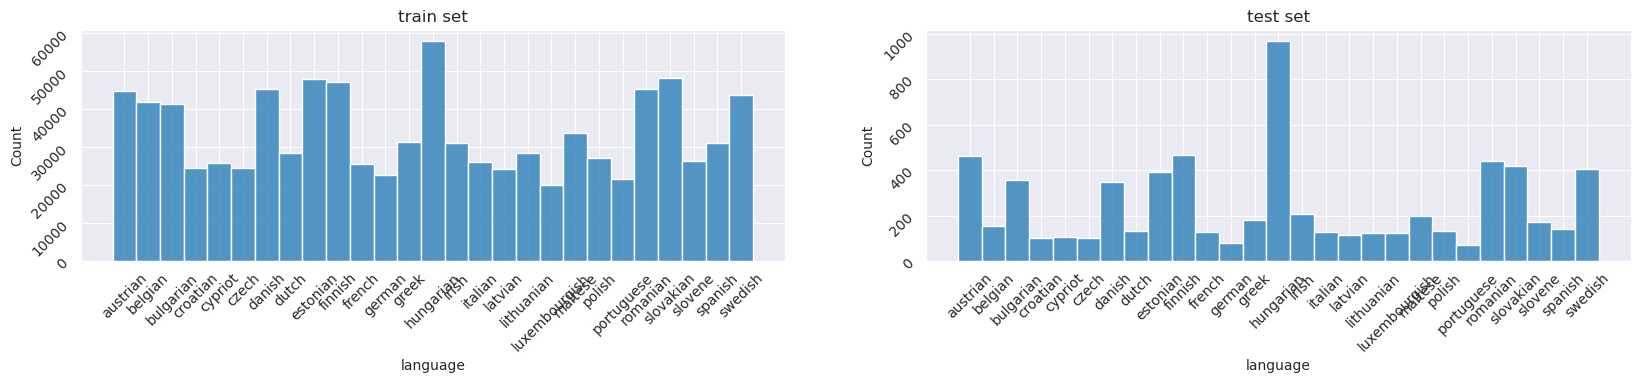

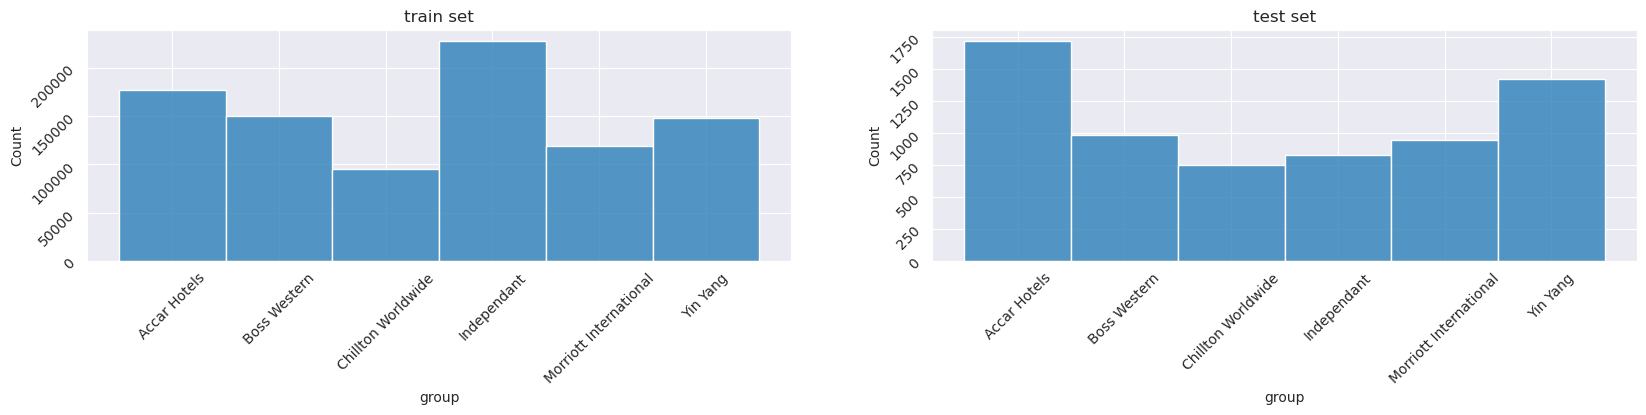

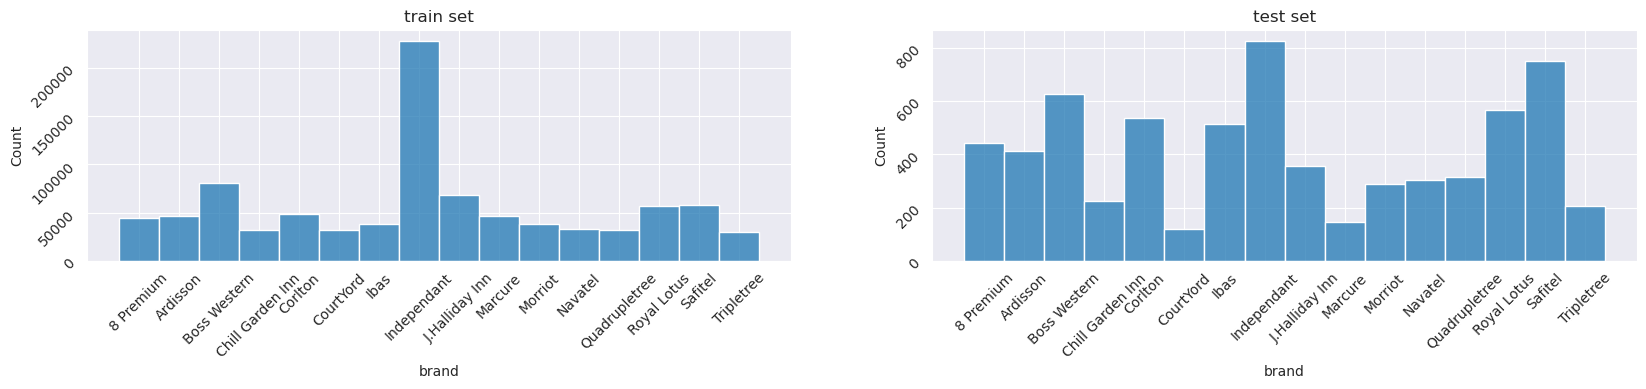

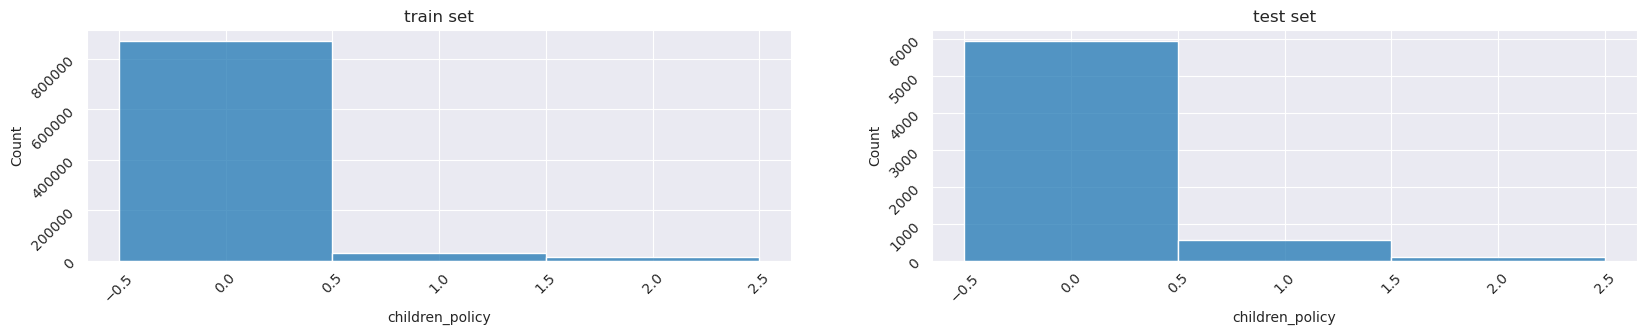

In [23]:
for col in colQL:
    fig, axes = plt.subplots(1, 2, figsize=(20, 3))
    sns.histplot(ax = axes[0], x = data[col])
    sns.histplot(ax = axes[1], x = data_test[col])
    axes[0].tick_params(labelrotation=45)
    axes[1].tick_params(labelrotation=45)
    axes[0].set_title('train set')
    axes[1].set_title('test set')
    plt.show()

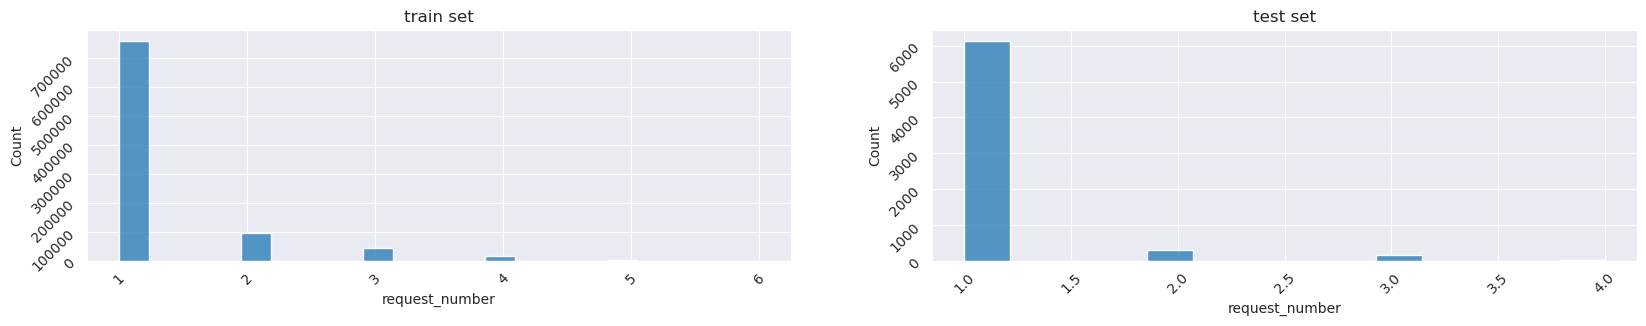

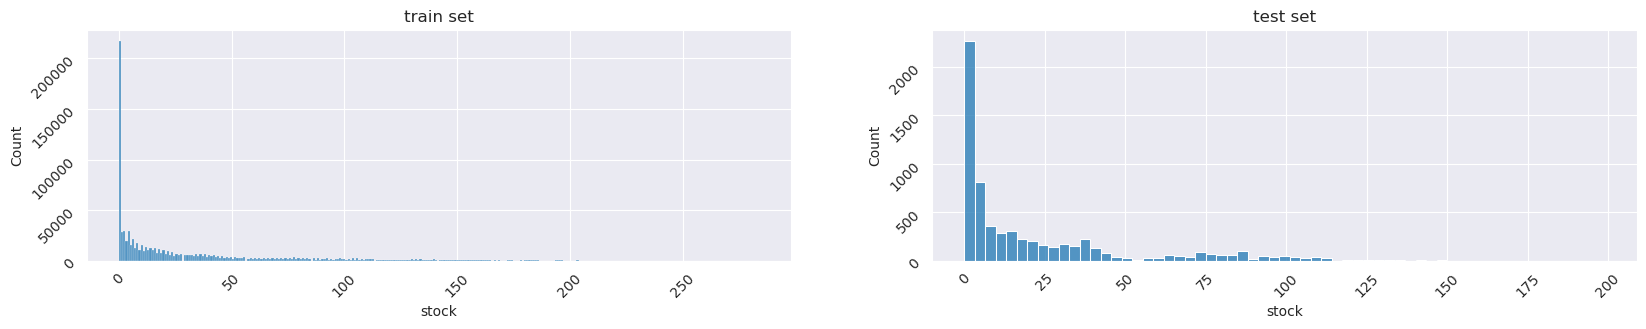

In [24]:
for col in colQT[:-1]:
        fig, axes = plt.subplots(1, 2, figsize=(20, 3))
        sns.histplot(ax = axes[0], x = data[col])
        sns.histplot(ax = axes[1], x = data_test[col])
        axes[0].tick_params(labelrotation=45)
        axes[1].tick_params(labelrotation=45)
        axes[0].set_title('train set')
        axes[1].set_title('test set')
        plt.show()

Globalement nous avons réussi à obtenir une distribution assez similaire dans notre $train$ $set$ pour qu'il ressemble au $test$ $set$ donné. On remarque tout de même que l'on explore un peu plus que le $train$, ce qui est normal compte tenu des différentes phases d'exploration que nous avons faites.

## Etude bidimensionnelle

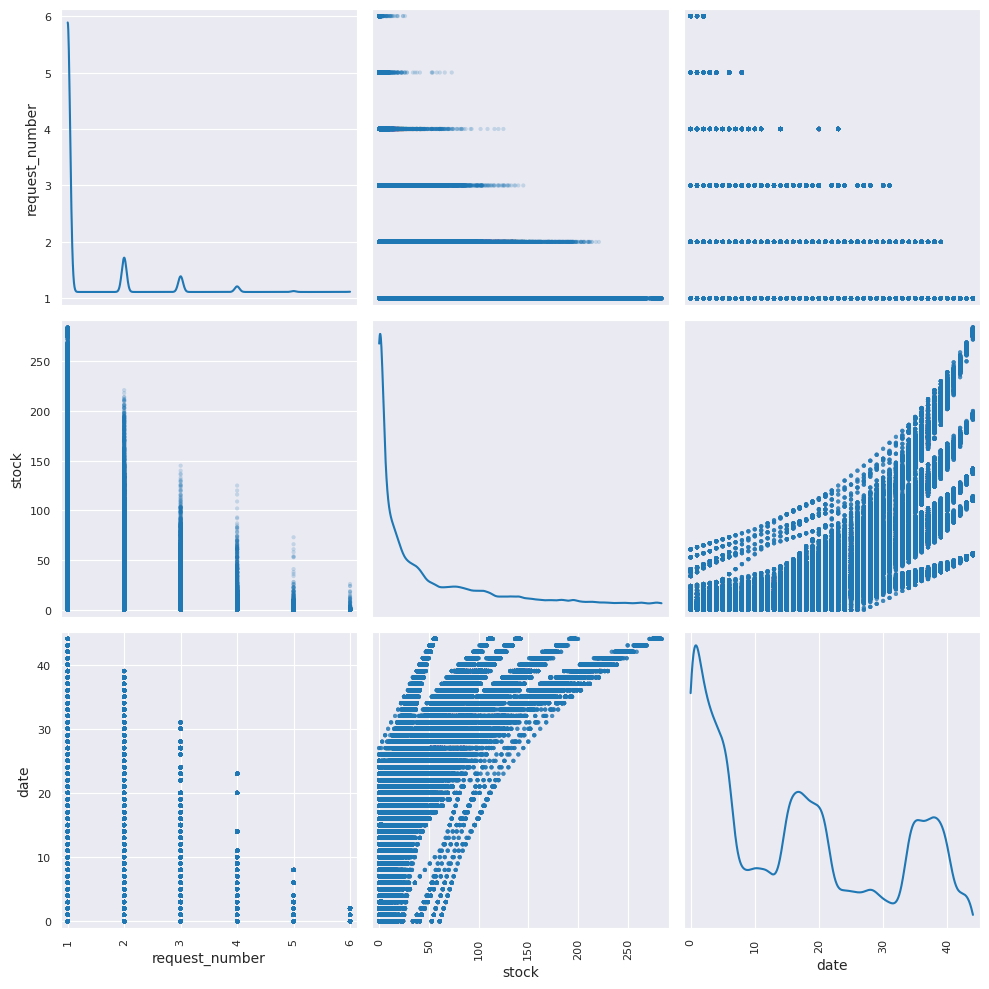

In [25]:
scatter_matrix(data[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

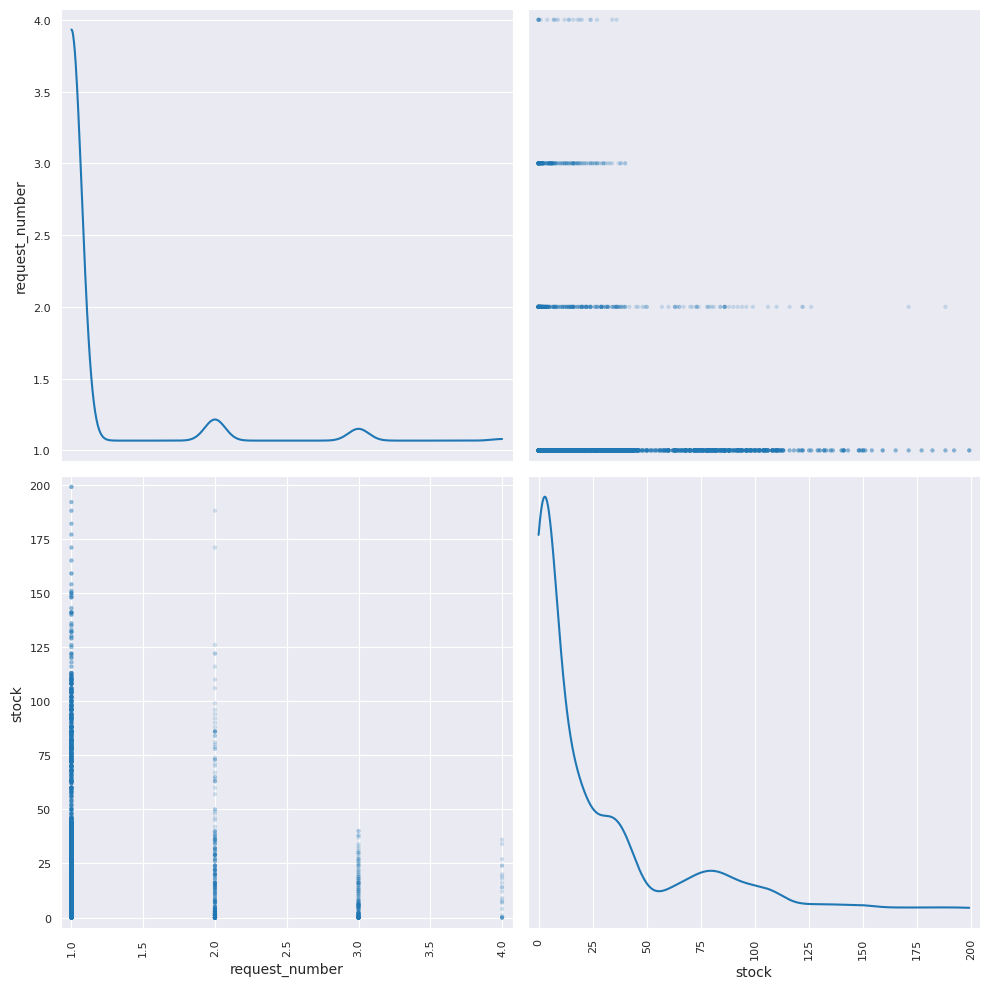

In [26]:
scatter_matrix(data_test[colQT[:-1]], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

On observe que la variable price à tendance à augmenter lorsqu'un utilisateur effectue plusieurs requête, la variable stock à quant-à elle tendance à diminuer en fonction de requestNumber (ceci étant dût au fait que 2 requêtes sont chronologiquement liées et que stock diminu avec le temps restant avant la réservation).

# Analyse du paramètre langue

Nous avons remarqué un écart de prix en moyenne pour un même hotel avec des langues différentes. Nous allons essayer ici de détailler cela.

In [4]:
path = './data/' 
data_lang = pd.read_csv(path + 'data_language_utility.csv')

In [5]:
dic_lang = {'amsterdam':'dutch', 'copenhagen':'danish',
            'madrid':'spanish', 'paris':'french',
            'rome':'italian', 'sofia':'bulgarian',
            'valletta':'maltese', 'vienna':'austrian',
            'vilnius':'lithuanian'}
data_lang['city_language'] = data_lang['city'].map(dic_lang)
data_lang['is_same_cl'] = data_lang['city_language']==data_lang['language']

In [6]:
data_diff_city = data_lang.loc[data_lang['is_same_cl'] == False].merge(data_lang.loc[data_lang['is_same_cl'] == True], on = ['city','date','mobile','hotel_id'])
data_diff_city['price_diff'] = (data_diff_city['price_y']-data_diff_city['price_x'])/data_diff_city['price_x']
data_diff_city = data_diff_city[['city','date','language_x','mobile','hotel_id','price_diff']]
data_diff_city.sort_values('price_diff', inplace = True)

In [7]:
data_diff_city_grouped = data_diff_city.groupby(['city','date','language_x','mobile']).agg({'price_diff':['mean','var']})#.price
data_diff_city_grouped = data_diff_city.groupby(['city','language_x']).agg({'price_diff':['mean','var']})#.price
grouped = data_lang.groupby(['city','date','mobile','hotel_id','is_same_cl']).agg({'price':['mean','var']})#mean()
grouped = grouped.reset_index()

In [8]:
grouped['sign_mean'] = - grouped.price['mean'] * grouped.is_same_cl + grouped.price['mean'] * (1-grouped.is_same_cl)

In [9]:
def percentage(x):
    """ alpha = 1.96 borne à 95% pour la loi normale  """
    moy = x.sum()
    return moy/x.max()

percentage.__name__ = 'percentage'

In [10]:
grouped['price_mean']=grouped.price['mean']
grouped['price_var']=grouped.price['var']
grouped.drop('price',axis=1,inplace=True)
grouped = grouped.droplevel(level=1, axis=1)

/tmp/ipykernel_55505/3322184548.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  grouped.drop('price',axis=1,inplace=True)


In [11]:
df2 = grouped[['city','date','mobile','hotel_id','price_mean']].groupby(['city','date','mobile','hotel_id']).agg({'price_mean': [percentage]})

In [12]:
print(f'percentage diff mean : {df2.price_mean.percentage.mean()}')
print(f'percentage diff var : {df2.price_mean.percentage.var()}')

percentage diff mean : 1.9711529825723841
percentage diff var : 0.0002941680171949088


### On peut donc affirmer avec quasi-certitude que les personnes parlant la langue du pays dans lequel elles cherchent un hotel paient en moyenne 1.97% de moins que les autres

Le problème est que ceci est une moyenne et il faudrait trouver pour chaque combinaison (pays, langue) le pourcentage en + ou en - sur le prix de la réservation. Sans pouvoir plus creuser cette piste, nous nous contenterons d'ajouter une colonne permettant de savoir si un utilisateur à la langue qui va avec son pays.